<a href="https://colab.research.google.com/github/yashmith-r/FaceRecognTechqs-DIPproj/blob/main/EigenFace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import random
import shutil
import cv2
from tqdm import tqdm

# Define paths to the dataset
PINS_DIR = os.path.join("C:\\", "Users", "91983", "OneDrive", "Desktop", "DIP Lab Project", "pins")
OUTPUT_DIR = "pins_subset"  # Directory for the subset
NUM_PEOPLE = 11  # Number of people to include
IMAGES_PER_PERSON = 100  # Number of images per person

# Step 1: List all folders (celebrities) in the dataset directory
celebrity_folders = [f for f in os.listdir(PINS_DIR) if os.path.isdir(os.path.join(PINS_DIR, f))]

# Check if there are enough celebrity folders
if len(celebrity_folders) < NUM_PEOPLE:
    raise ValueError(f"Dataset has only {len(celebrity_folders)} unique people, but {NUM_PEOPLE} are required.")

# Step 2: Randomly select NUM_PEOPLE celebrity folders
selected_folders = random.sample(celebrity_folders, NUM_PEOPLE)
print("Selected celebrity folders:", selected_folders)

# Step 3: Create output directory for the subset
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Step 4: Process and select images for each selected celebrity
print("Creating subset dataset...")
for celebrity in tqdm(selected_folders, desc="Processing celebrities"):
    # Get the path to the celebrity folder
    celebrity_dir = os.path.join(PINS_DIR, celebrity)

    # Get all image files in the celebrity folder
    image_files = [f for f in os.listdir(celebrity_dir) if f.endswith('.jpg') or f.endswith('.png')]

    # Ensure the celebrity has enough images
    if len(image_files) < IMAGES_PER_PERSON:
        print(f"Warning: Celebrity {celebrity} has fewer than {IMAGES_PER_PERSON} images. Using all available images.")
        selected_files = image_files
    else:
        selected_files = random.sample(image_files, IMAGES_PER_PERSON)

    # Create the output folder for this celebrity
    celebrity_output_dir = os.path.join(OUTPUT_DIR, celebrity)
    if not os.path.exists(celebrity_output_dir):
        os.makedirs(celebrity_output_dir)

    # Copy the selected images to the new subset folder
    for img_file in selected_files:
        img_path = os.path.join(celebrity_dir, img_file)
        new_img_path = os.path.join(celebrity_output_dir, img_file)

        # Copy the image file to the new subset folder
        shutil.copy(img_path, new_img_path)

print("Subset dataset created successfully.")


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\91983\\OneDrive\\Desktop\\DIP Lab Project\\pins'

## Applying Gaussian Blur to the image

In [ ]:
import os
import cv2
from tqdm import tqdm

# Input and output directories
INPUT_DIR = "pins_subset"  # Directory containing the subset dataset
OUTPUT_DIR = "pins_blurred"  # Directory to save blurred images

# Create the output directory if it doesn't exist
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Blur kernel size
BLUR_KERNEL = (5, 5)  # You can adjust this to (3, 3) or (7, 7) for varying blur levels

# Function to apply Gaussian blur to an image
def apply_blur(image_path, save_path):
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Could not read image {image_path}")
        return
    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(image, BLUR_KERNEL, 0)
    # Save the blurred image
    cv2.imwrite(save_path, blurred)

# Process each folder in the dataset
print("Applying blur to images...")
for person in tqdm(os.listdir(INPUT_DIR), desc="Processing folders"):
    person_dir = os.path.join(INPUT_DIR, person)
    if not os.path.isdir(person_dir):
        continue

    # Create corresponding folder in the output directory
    blurred_person_dir = os.path.join(OUTPUT_DIR, person)
    os.makedirs(blurred_person_dir, exist_ok=True)

    # Process each image in the person's folder
    for image_file in os.listdir(person_dir):
        image_path = os.path.join(person_dir, image_file)
        save_path = os.path.join(blurred_person_dir, image_file)
        apply_blur(image_path, save_path)

print("Blurring completed. Blurred dataset saved in:", OUTPUT_DIR)


Applying blur to images...


Processing folders: 100%|██████████| 38/38 [00:57<00:00,  1.50s/it]

Blurring completed. Blurred dataset saved in: pins_blurred


In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Path to blurred dataset
DATASET_DIR = "pins_blurred"

# Parameters
IMG_SIZE = (128, 128)  # Resize images to this size for uniformity

# Function to load and preprocess dataset
def load_dataset(dataset_dir):
    images, labels = [], []
    for person in os.listdir(dataset_dir):
        person_dir = os.path.join(dataset_dir, person)
        if not os.path.isdir(person_dir):
            continue
        for image_file in os.listdir(person_dir):
            image_path = os.path.join(person_dir, image_file)
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read in grayscale
            if img is None:
                print(f"Warning: Could not read image {image_path}")
                continue
            img = cv2.resize(img, IMG_SIZE)  # Resize image
            images.append(img)
            labels.append(person)
    return np.array(images), np.array(labels)

# Load dataset
print("Loading dataset...")
X, y = load_dataset(DATASET_DIR)

# Encode labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Normalize images
X_train = X_train / 255.0  # Normalize pixel values to [0, 1]
X_test = X_test / 255.0

print(f"Dataset loaded and split: {X_train.shape[0]} training images, {X_test.shape[0]} testing images.")


Loading dataset...
Dataset loaded and split: 3216 training images, 805 testing images.


Eigenfaces (PCA) Classification Accuracy: 17.52%


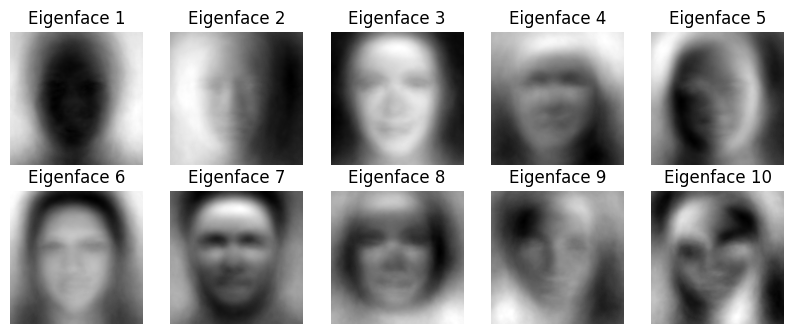

In [ ]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Flatten images from 2D to 1D
n_samples, h, w = X_train.shape
X_train_flat = X_train.reshape(n_samples, h * w)
X_test_flat = X_test.reshape(X_test.shape[0], h * w)

# Step 1: Perform PCA
n_components = 50  # Number of principal components to use
pca = PCA(n_components=n_components, whiten=True).fit(X_train_flat)

# Step 2: Transform the data to PCA space
X_train_pca = pca.transform(X_train_flat)
X_test_pca = pca.transform(X_test_flat)

# Step 3: Train a classifier (SVM) on PCA components
svm = SVC(kernel='linear', class_weight='balanced')
svm.fit(X_train_pca, y_train)

# Step 4: Predict using the classifier
y_pred = svm.predict(X_test_pca)

# Step 5: Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Eigenfaces (PCA) Classification Accuracy: {accuracy * 100:.2f}%")

# Visualizing the first few eigenfaces
eigenfaces = pca.components_.reshape((n_components, h, w))
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow(eigenfaces[i], cmap='gray')
    plt.title(f"Eigenface {i + 1}")
    plt.axis('off')
plt.show()


Loading dataset...
Classes in dataset: ['Adriana Lima' 'Amanda Crew' 'Avril Lavigne' 'Bill Gates'
 'Brian J. Smith' 'Brie Larson' 'Chris Hemsworth' 'Chris Pratt'
 'Christian Bale' 'Dwayne Johnson' 'Emma Stone' 'Emma Watson'
 'Gwyneth Paltrow' 'Henry Cavil' 'Irina Shayk' 'Jeremy Renner'
 'Jimmy Fallon' 'Lili Reinhart' 'Lionel Messi' 'Logan Lerman'
 'Madelaine Petsch' 'Maria Pedraza' 'Mark Ruffalo' 'Miley Cyrus'
 'Pedro Alonso' 'Rami Malek' 'Sarah Wayne Callies' 'Selena Gomez'
 'Stephen Amell' 'Taylor Swift' 'Tom Cruise' 'Zendaya' 'Zoe Saldana'
 'barack obama' 'barbara palvin' 'camila mendes' 'elon musk'
 'margot robbie']
Classification Report:
                     precision    recall  f1-score   support

       Adriana Lima       0.09      0.10      0.10        20
        Amanda Crew       0.29      0.50      0.36        20
      Avril Lavigne       0.10      0.10      0.10        20
         Bill Gates       0.27      0.30      0.29        20
     Brian J. Smith       0.29      0.30   

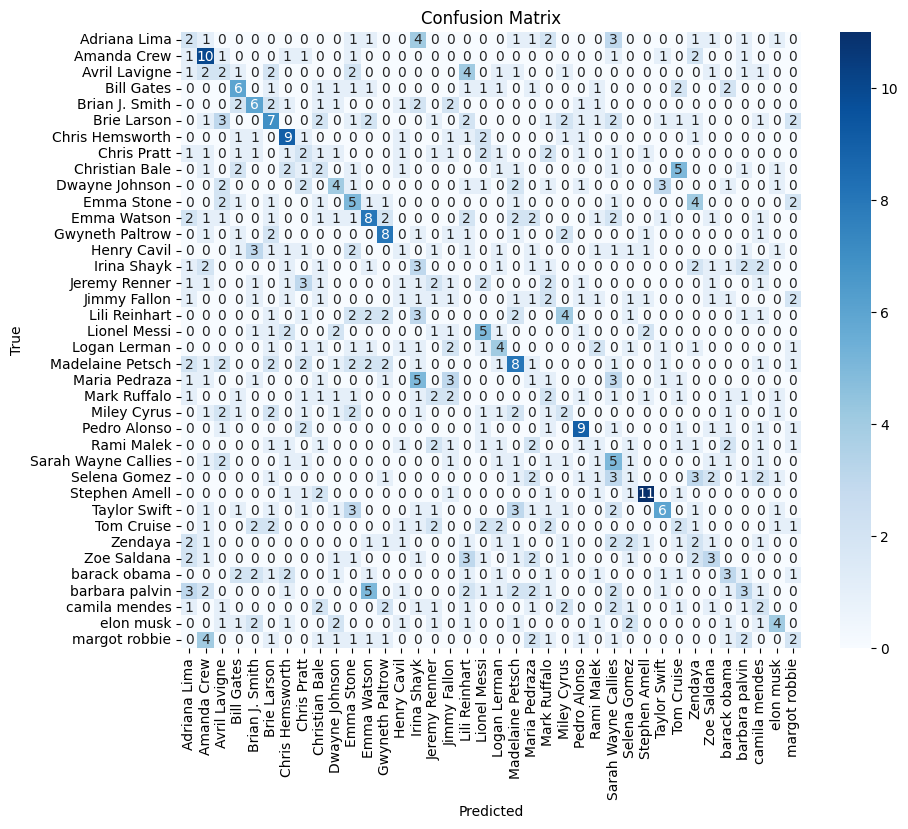

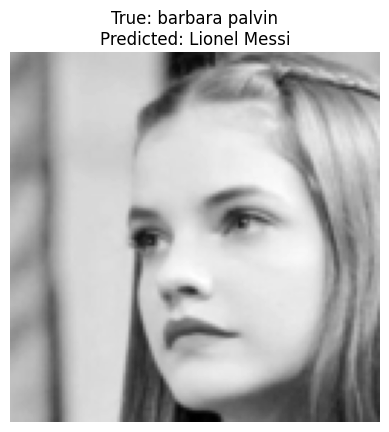

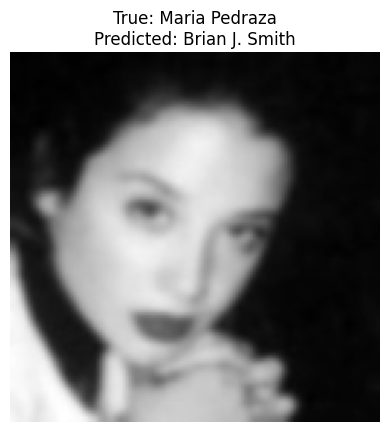

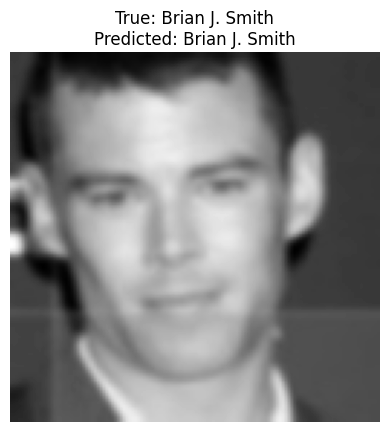

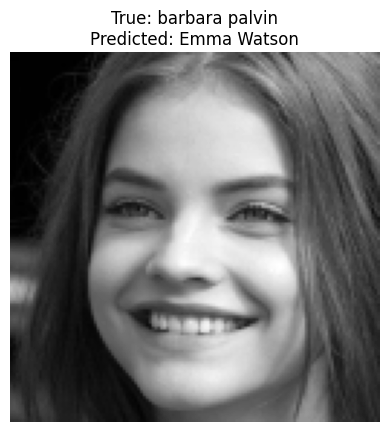

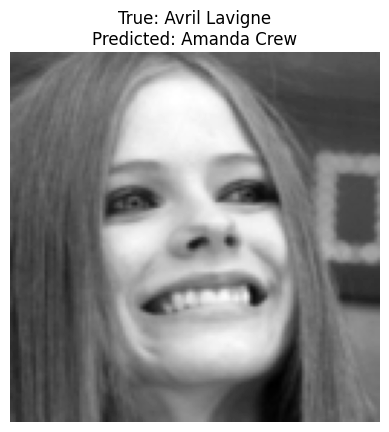

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Path to blurred dataset
DATASET_DIR = "pins_blurred"
IMG_SIZE = (128, 128)  # Resize images to this size for uniformity
N_COMPONENTS = 150  # Number of PCA components

# Function to load and preprocess dataset
def load_dataset(dataset_dir):
    images, labels = [], []
    for person in os.listdir(dataset_dir):
        person_dir = os.path.join(dataset_dir, person)
        if not os.path.isdir(person_dir):
            continue
        for image_file in os.listdir(person_dir):
            image_path = os.path.join(person_dir, image_file)
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read in grayscale
            if img is None:
                print(f"Warning: Could not read image {image_path}")
                continue
            img = cv2.resize(img, IMG_SIZE).flatten()  # Flatten for PCA
            images.append(img)
            labels.append(person)
    return np.array(images), np.array(labels)

# Load dataset
print("Loading dataset...")
X, y = load_dataset(DATASET_DIR)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print("Classes in dataset:", label_encoder.classes_)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Normalize images
X_train = X_train / 255.0
X_test = X_test / 255.0

# Apply PCA
pca = PCA(n_components=N_COMPONENTS, whiten=True)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train a classifier (SVM)
svc = SVC(kernel='linear', probability=True)
svc.fit(X_train_pca, y_train)

# Evaluate the model
y_pred = svc.predict(X_test_pca)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Display five random predictions
indices = np.random.choice(len(X_test), 5, replace=False)
for idx in indices:
    img = X_test[idx].reshape(IMG_SIZE[0], IMG_SIZE[1])
    true_label = label_encoder.inverse_transform([y_test[idx]])[0]
    predicted_label = label_encoder.inverse_transform([y_pred[idx]])[0]
    plt.imshow(img, cmap="gray")
    plt.title(f"True: {true_label}\nPredicted: {predicted_label}")
    plt.axis("off")
    plt.show()
